# SML 301
## Session 2: Linear Regression

* linear regression
* model diagnostics
* train-test split
* polynomial regression
* multilinear regression
* penalization

Remember to "Save Copy to Drive" to use your own cloud space.

In [28]:
# install packages (if need be)
# %pip install palmerpenguins

In [29]:
# load libraries
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from palmerpenguins import load_penguins
from scipy import stats
from sklearn import linear_model
from sklearn.linear_model import LinearRegression, RidgeCV, LassoCV, ElasticNetCV
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import PolynomialFeatures

# Princeton colors
# orange on white: #e77500
# orange on black: #f58025

# load data
penguins = load_penguins()
penguins.head()

,species,island,bill_length_mm,bill_depth_mm,flipper_length_mm,body_mass_g,sex,year
0,Adelie,Torgersen,39.1,18.7,181.0,3750.0,male,2007
1,Adelie,Torgersen,39.5,17.4,186.0,3800.0,female,2007
2,Adelie,Torgersen,40.3,18.0,195.0,3250.0,female,2007
3,Adelie,Torgersen,NaN,NaN,NaN,NaN,NaN,2007
4,Adelie,Torgersen,36.7,19.3,193.0,3450.0,female,2007


# Matplotlib: Axes over plt.plot()

In general, the **axes interface** in `matplotlib` offers more customization over data visuals than the `plt.plot()` interface. In this course, I proceed with the axes interface.

## Scatterplot

A **scatterplot** shows two numerical variables, and we then add code to plot a best-fit line for linear regression.

In this first example, we try to predict a penguin's bill length based on its body mass.

In [30]:
penguins_subset = penguins[["bill_length_mm", "body_mass_g"]] #subset with just the variables that we need
penguins_subset = penguins_subset.dropna()                    #then remove missing data
X = penguins_subset["body_mass_g"]
y = penguins_subset["bill_length_mm"]

Text(0, 0.5, 'body mass (g)')

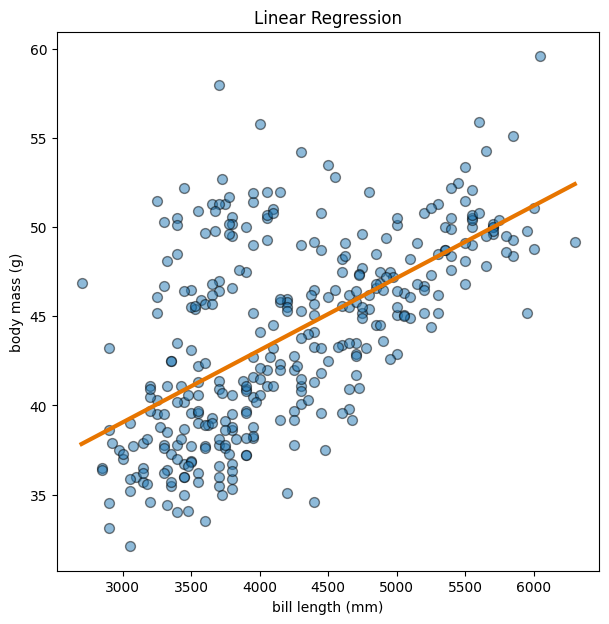

In [31]:
# https://python-graph-gallery.com/scatterplot-with-regression-fit-in-matplotlib/
# # Initialize layout
fig, ax = plt.subplots(figsize=(7, 7))

# Add scatterplot
ax.scatter(X, y, s=50, alpha=0.5, edgecolors="#000000")

# Add best-fit line
b, a = np.polyfit(X, y, deg = 1)
xseq = np.linspace(min(X), max(X), num = 301)
ax.plot(xseq, a + b*xseq, color = "#e77500", lw = 3)

# Label plot
ax.set_title("Linear Regression")
ax.set_xlabel("bill length (mm)")
ax.set_ylabel("body mass (g)")


In [32]:
penguins_subset = penguins[["bill_length_mm", "body_mass_g"]] #subset with just the variables that we need
penguins_subset = penguins_subset.dropna()                    #then remove missing data
X = penguins_subset[["body_mass_g"]]                          #later: needs to be a 2D array
y = penguins_subset["bill_length_mm"]

# linear regression modeling (via scikit-learn)
model = LinearRegression().fit(X, y)

Linear regression math model:

$y = \beta_{0} + \beta_{1}X_{1}$

In [33]:
# show model coefficients
print("beta_0:", model.intercept_)
print("beta_1:", model.coef_)

beta_0: 26.898872423598547
beta_1: [0.00405142]


# Model Diagnositics

Following discussion in the *ISLP* textbook, we proceed to perform some diagnostics on the linear regression process.

In [34]:
# helper functions by a-martyn (https://github.com/a-martyn)
def lm_stats(X, y, y_pred):
    """ LEVERAGE & STUDENTISED RESIDUALS
    - https://en.wikipedia.org/wiki/Studentized_residual#How_to_studentize
    """
    # Responses as np array vector
    try:
        y.shape[1] == 1
        # take first dimension as vector
        y = y.iloc[:,0]
    except:
        pass
    y = np.array(y)

    # Residuals
    residuals = np.array(y - y_pred)

    # Hat matrix
    H = np.array(X @ np.linalg.inv(X.T @ X)) @ X.T

    # Leverage
    #h_ii = H.diagonal()
    h_ii = np.diag(H)

    ## Externally studentised residual
    # In this case external studentisation is most appropriate
    # because we are looking for outliers.

    # Estimate variance (externalised)
    σi_est = []
    for i in range(X.shape[0]):
        # exclude ith observation from estimation of variance
        external_residuals = np.delete(residuals, i)
        σi_est += [np.sqrt((1 / (X.shape[0] - X.shape[1] - 1)) * np.sum(np.square(external_residuals)))]
    σi_est = np.array(σi_est)

    # Externally studentised residuals
    t = residuals / σi_est * np.sqrt(1 - h_ii)


    # Return dataframe
    return pd.DataFrame({'residual': residuals,
                         'leverage': h_ii,
                         'studentised_residual': t,
                         'y_pred': y_pred})


def lm_plot(lm_stats_df):
    """Provides R style residual plots based on results from lm_stat()"""
    # Parse stats
    t      = lm_stats_df['studentised_residual']
    h_ii   = lm_stats_df['leverage']
    y_pred = lm_stats_df['y_pred']

    # setup axis for grid
    plt.figure(1, figsize=(16, 18))

    # Studentised residual plot
    plt.subplot(321)
    ax = sns.regplot(x=y_pred, y=t, lowess=True)
    plt.xlabel('Fitted values')
    plt.ylabel('Studentised residuals')
    plt.title('Externally studentised residual plot', fontweight='bold')
    # Draw Hastie and Tibshirani's bounds for possible outliers
    ax.axhline(y=3, color='r', linestyle='dashed')
    ax.axhline(y=-3, color='r', linestyle='dashed');

    # Normal Q-Q plot
    plt.subplot(322)
    ax = stats.probplot(t, dist='norm', plot=plt)
    plt.ylabel('Studentised residuals')
    plt.title('Normal Q-Q', fontweight='bold')

    # Standardised residuals
    plt.subplot(323)
    ax = sns.regplot(x=y_pred, y=np.sqrt(np.abs(t)), lowess=True)
    plt.xlabel('Fitted values')
    plt.ylabel('√Standardized residuals')
    plt.title('Scale-Location', fontweight='bold')

    # Residuals vs Leverage plot
    plt.subplot(324)
    ax = sns.scatterplot(x=h_ii, y=t)
    plt.xlabel('Leverage')
    plt.ylabel('Studentised residuals')
    plt.title('Externally studentised residual vs Leverage', fontweight='bold');

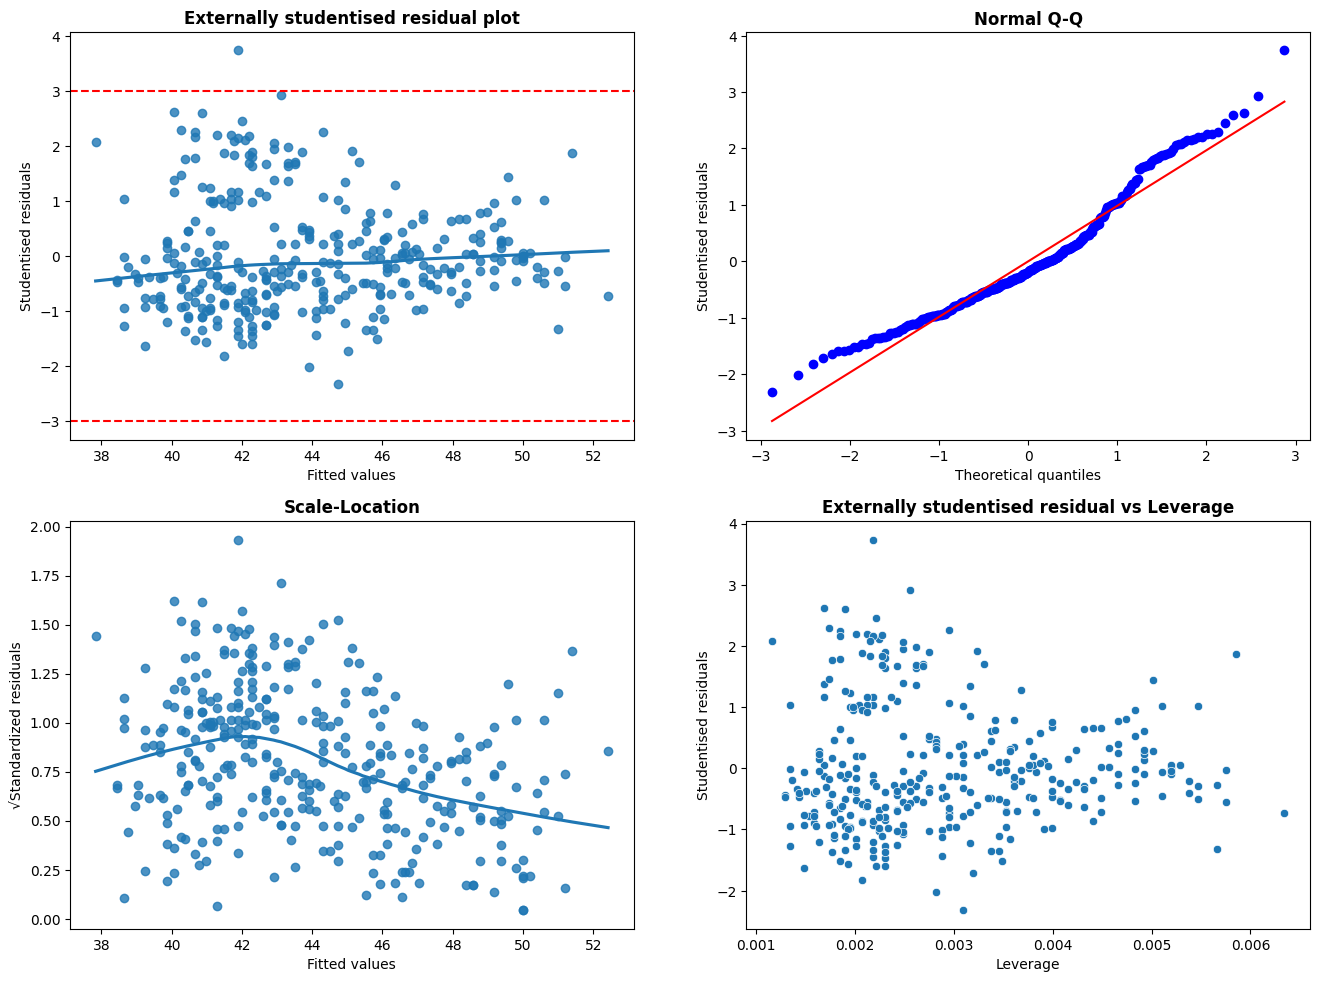

In [35]:
# produce predictions
y_pred = model.predict(X)

# Analyse residuals
lm_plot(lm_stats(X, y, y_pred))
plt.show()

# Train-Test Split

Moving toward model evaluation, we should get in the habit of partitioning our data into a **training set** and **test set**

In [36]:
X = penguins_subset[["body_mass_g"]]
y = penguins_subset["bill_length_mm"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 301)

Text(0, 0.5, 'body mass (g)')

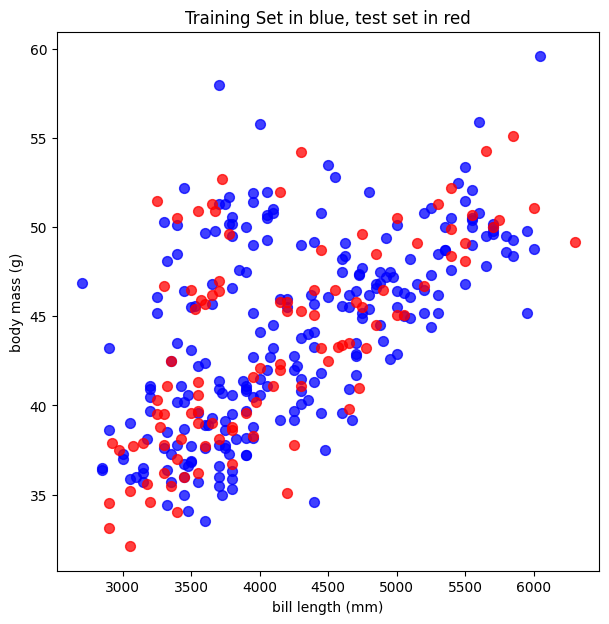

In [37]:
# Initialize layout
fig, ax = plt.subplots(figsize=(7, 7))

# Add scatterplot
ax.scatter(X_train, y_train, s=50, alpha=0.75, color = "blue")
ax.scatter(X_test, y_test, s=50, alpha=0.75, color = "red")

# Label plot
ax.set_title("Training Set in blue, test set in red")
ax.set_xlabel("bill length (mm)")
ax.set_ylabel("body mass (g)")

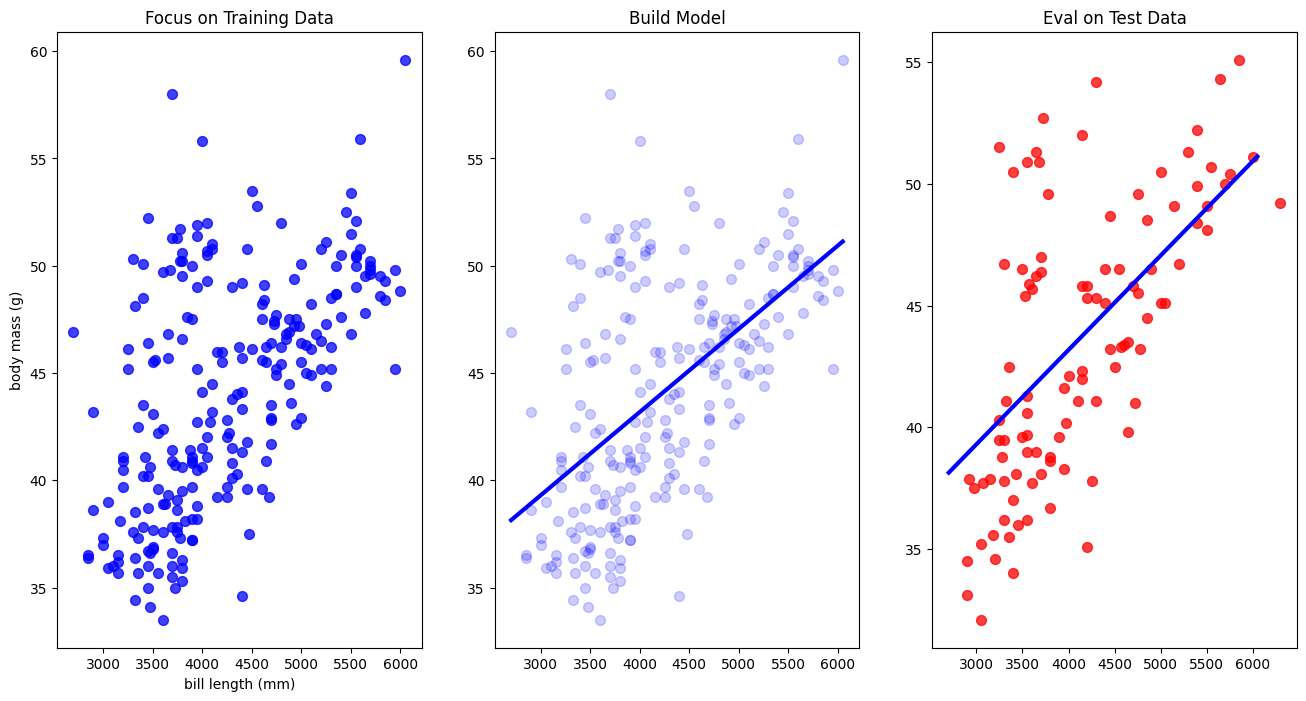

In [38]:
# Initialize subplot layout
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(16, 8))

ax1.scatter(X_train, y_train, s=50, alpha=0.75, color = "blue")
ax1.set_title("Focus on Training Data")
ax1.set_xlabel("bill length (mm)")
ax1.set_ylabel("body mass (g)")

ax2.scatter(X_train, y_train, s=50, alpha=0.2, color = "blue")
ax2.set_title("Build Model")
b, a = np.polyfit(X_train["body_mass_g"], y_train, deg = 1)
xseq = np.linspace(min(X_train["body_mass_g"]), max(X_train["body_mass_g"]), num = 301)
ax2.plot(xseq, a + b*xseq, color = "blue", lw = 3)

ax3.scatter(X_test, y_test, s=50, alpha=0.75, color = "red")
ax3.set_title("Eval on Test Data")
ax3.plot(xseq, a + b*xseq, color = "blue", lw = 3)


In [39]:
model = LinearRegression().fit(X_train, y_train)

We then **evaluate** the model on the *test data*.  For regression tasks, a common *metric* is **MSE** (mean-squared error)

$\text{MSE} = \frac{1}{n}\sum_{i=1}^{n}(\hat{y}_{i} - y_{i})^{2}$

In [40]:
y_pred = model.predict(X_test)
model_MSE = mean_squared_error(y_test, y_pred)
print(f'test MSE: {model_MSE:.4f}')

test MSE: 18.4755


# Polynomial Regression

$\hat{y} = \beta_{0} + \beta_{1}X_{1} + \beta_{2}X_{1}^{2}$

$\hat{y} = \beta_{0} + \beta_{1}X_{1} + \beta_{2}X_{1}^{2} + \beta_{3}X_{1}^{3}$

In [41]:
# degree 2 polynomial
poly_setup = PolynomialFeatures(degree = 2, include_bias = False).fit_transform(X_train)
model = LinearRegression().fit(poly_setup, y_train)

# show model coefficients
print("beta_0:", model.intercept_)
print("betas:", model.coef_)

poly_setup = PolynomialFeatures(degree = 2, include_bias = False).fit_transform(X_test)
y_pred = model.predict(poly_setup)
model_MSE = mean_squared_error(y_test, y_pred)
print(f'test MSE: {model_MSE:.4f}')

beta_0: 29.04071872919326
betas: [3.23458158e-03 7.28637330e-08]
test MSE: 18.5154


In [42]:
# degree 3 polynomial
poly_setup = PolynomialFeatures(degree = 3, include_bias = False).fit_transform(X_train)
model = LinearRegression().fit(poly_setup, y_train)

# show model coefficients
print("beta_0:", model.intercept_)
print("betas:", model.coef_)

poly_setup = PolynomialFeatures(degree = 3, include_bias = False).fit_transform(X_test)
y_pred = model.predict(poly_setup)
model_MSE = mean_squared_error(y_test, y_pred)
print(f'test MSE: {model_MSE:.4f}')

beta_0: 13.201870201004642
betas: [ 1.45591024e-02 -2.56467337e-06  2.00152243e-10]
test MSE: 18.3806


# Multilinear Regression

$\hat{y} = \beta_{0} + \beta_{1}X_{1} + \beta_{2}X_{2}$

In [43]:
penguins_subset = penguins[["bill_length_mm", "body_mass_g", "flipper_length_mm"]] #subset with just the variables that we need
penguins_subset = penguins_subset.dropna()                                         #then remove missing data
X = penguins_subset[["body_mass_g", "flipper_length_mm"]]
y = penguins_subset["bill_length_mm"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 301)

model = LinearRegression().fit(X_train, y_train)

# show model coefficients
print("beta_0:", model.intercept_)
print("betas:", model.coef_)

y_pred = model.predict(X_test)
model_MSE = mean_squared_error(y_test, y_pred)
print(f'test MSE: {model_MSE:.4f}')

beta_0: -3.512948966423032
betas: [0.00042458 0.22721905]
test MSE: 16.4660


# Penalization

Later, we will discuss the notion of *variance* (in the test set error totals) for machine learning.  For now, we try out **penalization** methods to suppress some of the coefficients to try to reduce variance.

## Ridge Regression

$\hat{y} = \beta_{0} + \beta_{1}X_{1} + \beta_{2}X_{2} + \alpha\sum_{i = 1}^{2} \beta_{i}^{2}$

where $\alpha > 0$ is the penalization coefficient.

* ridge regression is also called **L2 penalization**

In [44]:
ridge_grid = RidgeCV(alphas = [0.001, 0.01, 0.1, 1.0, 10.0, 100, 1000])
model = ridge_grid.fit(X_train, y_train)

# show model coefficients
print("alpha:", model.alpha_)
print("beta_0:", model.intercept_)
print("betas:", model.coef_)

y_pred = model.predict(X_test)
model_MSE = mean_squared_error(y_test, y_pred)
print(f'test MSE: {model_MSE:.4f}')

alpha: 100.0
beta_0: -3.244404996952511
betas: [0.0004543  0.22526271]
test MSE: 16.4630


## LASSO Regression

$\hat{y} = \beta_{0} + \beta_{1}X_{1} + \beta_{2}X_{2} + \alpha\sum_{i = 1}^{2} |\beta_{i}|$

where $\alpha > 0$ is the penalization coefficient.

* LASSO regression (least absolute shrinkage and selection operator) is also called **L1 penalization**

In [45]:
lasso_grid = LassoCV(alphas = [0.001, 0.01, 0.1, 1.0, 10.0, 100, 1000])
model = lasso_grid.fit(X_train, y_train)

# show model coefficients
print("alpha:", model.alpha_)
print("beta_0:", model.intercept_)
print("betas:", model.coef_)

y_pred = model.predict(X_test)
model_MSE = mean_squared_error(y_test, y_pred)
print(f'test MSE: {model_MSE:.4f}')

alpha: 0.1
beta_0: -3.225590182288883
betas: [0.00045654 0.22512234]
test MSE: 16.4627


# Preview: Grid Search

* we can try out several values of $\alpha$
* we can try out different penalization methods

The following code outlines the idea.  We create a Python *dictionary* of the hyperparameter values that we wish to explore, and run cross-validation on all of the proposed models.

In [46]:
#linear_models = linear_model.LinearRegression()
#alpha_space = np.logspace(-4, 4, 10)
#penalty = ["l1", "l2"]
#options = dict(alpha_space = alpha_space, penalty = penalty)
#grid_search = GridSearchCV(linear_models, options, cv = 5, verbose = 0)

#model = grid_search.fit(X_train, y_train)

For these penalized linear models, we proceed instead to **elastic net**, which is a linear combination of the previous ridge and LASSO ideas.

$\hat{y} = \beta_{0} + \beta_{1}X_{1} + \beta_{2}X_{2} + \alpha[L\sum_{i = 1}^{2} \beta_{i}^{2}+ (1-L)\sum_{i = 1}^{2} |\beta_{i}|]$

* $\alpha$: penalization coefficient
* $L$: $L1$ ratio

In [47]:
elastic_net_cv_model = ElasticNetCV(alphas = np.logspace(-4, 4, 10), l1_ratio = np.logspace(-1, 1, 10), cv = 5, random_state = 301)
model = elastic_net_cv_model.fit(X_train, y_train)

# show model coefficients
print(f"Optimal alpha: {model.alpha_}")
print(f"Optimal l1_ratio: {model.l1_ratio_}")
print("beta_0:", model.intercept_)
print("betas:", model.coef_)

y_pred = model.predict(X_test)
model_MSE = mean_squared_error(y_test, y_pred)
print(f'test MSE: {model_MSE:.4f}')

Optimal alpha: 2.782559402207126
Optimal l1_ratio: 0.1
beta_0: -1.222485117935264
betas: [0.00067773 0.21053929]
test MSE: 16.4518
